## Import Libraries/Test Images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Make a list of test images
test_image_names = glob.glob('./test_images/test*.jpg')
test_images = []

# Step through the list and search for chessboard corners
for fname in test_image_names:
    img = mpimg.imread(fname)
    test_images.append(img)
    
print(np.shape(test_images[0]))

(720, 1280, 3)


## Get Camera Calibration Coefficients

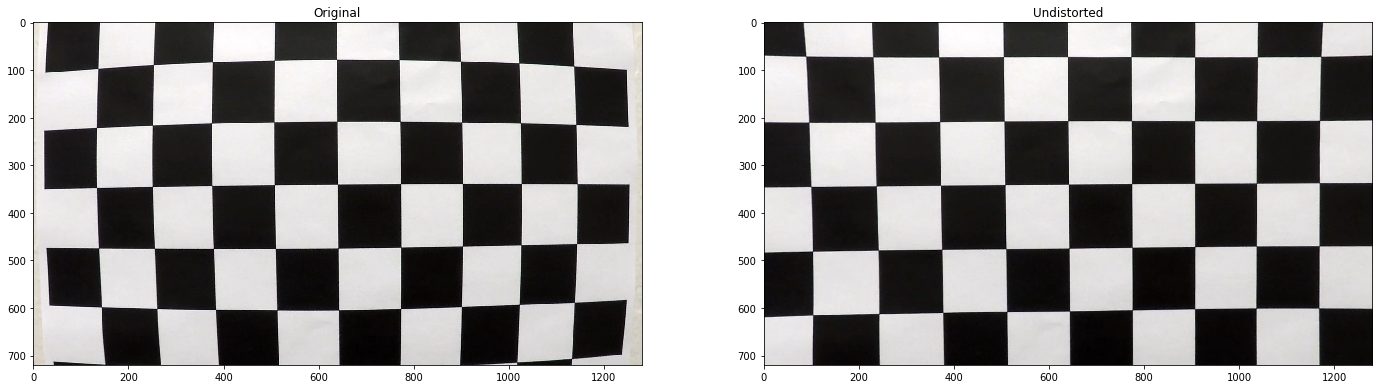

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#for fname in images:
#    img = cv2.imread(fname)
#    cv2.imshow('img',img)
#    cv2.waitKey(500)
#    img = cv2.undistort(img, mtx, dist, None, mtx)
#    cv2.imshow('img',img)
#    cv2.waitKey(500)
#
#cv2.destroyAllWindows()

img = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(undist)
ax2.set_title('Undistorted')

## Distortion Correction

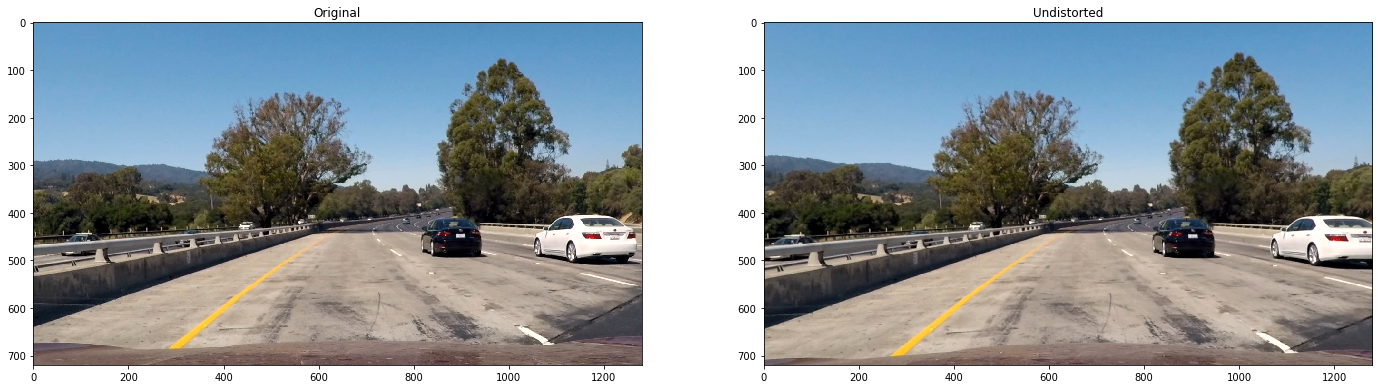

In [26]:
img = test_images[0]
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(undist)
ax2.set_title('Undistorted')

## Perspective Transform

720


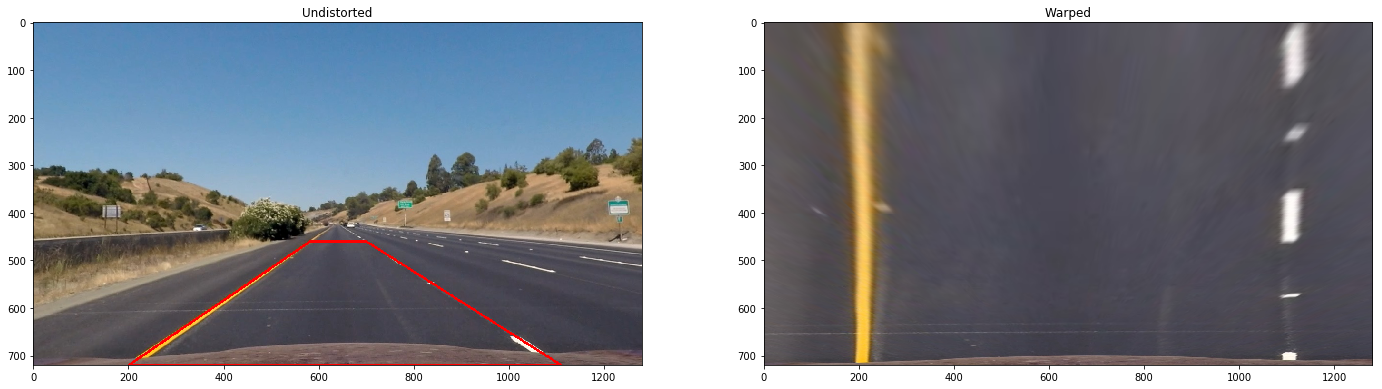

In [4]:
image = mpimg.imread('./test_images/straight_lines1.jpg')
#source and destination corners manually extracted
src_bottom_left = [200,720]
src_bottom_right = [1110, 720]
src_top_left = [582, 460]
src_top_right = [700, 460]
src = np.float32([src_bottom_left,src_bottom_right,src_top_left,src_top_right])

dst_bottom_left = [200,720]
dst_bottom_right = [1110, 720]
dst_top_left = [200, 0]
dst_top_right = [1110, 0]
dst = np.float32([dst_bottom_left,dst_bottom_right,dst_top_left,dst_top_right])

print(image.shape[0])
img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
undist = cv2.undistort(image, mtx, dist, None, mtx)

poly_corners = np.array([src_top_left,src_top_right,src_bottom_right,src_bottom_left], np.int32)
#pts = pts.reshape((-1,1,2))
copy = undist.copy()
cv2.polylines(copy,[poly_corners],True,(255,0,0), thickness=3)

warped = cv2.warpPerspective(undist, M, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(copy)
ax1.set_title('Undistorted')
ax2.imshow(warped)
ax2.set_title('Warped')

## Visualize Color Channels in RGB and HSV

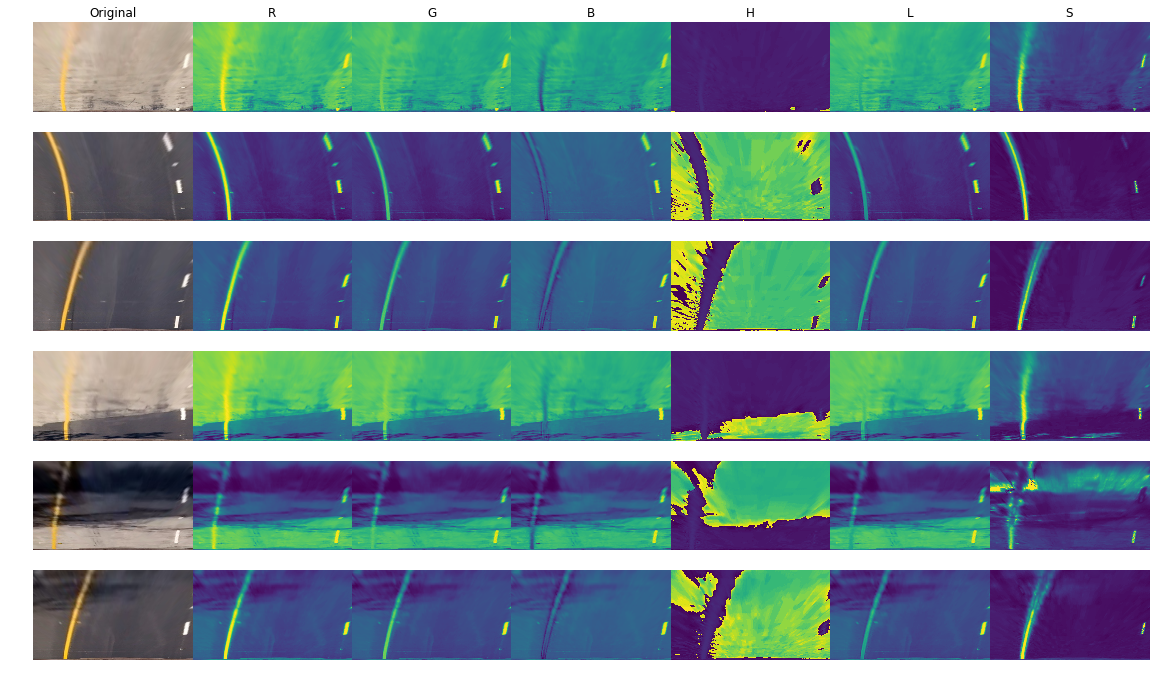

In [5]:
# Make a list of test images
test_r = []
test_g = []
test_b = []
test_h = []
test_s = []
test_v = []

# show image of 10 random data points
fig, axs = plt.subplots(len(test_images),7, figsize=(20, 12))
fig.subplots_adjust(hspace = .05, wspace=.001)
axs[0][0].set_title("Original")
axs[0][1].set_title("R")
axs[0][2].set_title("G")
axs[0][3].set_title("B")
axs[0][4].set_title("H")
axs[0][5].set_title("L")
axs[0][6].set_title("S")

for i in range(len(test_images)):
    for j in range(7):
        axs[i][j].axis('off')
    image = test_images[i]
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image = cv2.warpPerspective(image, M, img_size)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hsv[:,:,0]
    L = hsv[:,:,1]
    S = hsv[:,:,2]
    axs[i][0].imshow(image)
    axs[i][1].imshow(R)
    axs[i][2].imshow(G)
    axs[i][3].imshow(B)
    axs[i][4].imshow(H)
    axs[i][5].imshow(L)
    axs[i][6].imshow(S)


## Define Thresholding Functions

In [6]:
#Sobel threshold to detect gradient
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

#Directional threshold to detect direction of gradient
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

#RGB Color threshold to detect yellow/white lines
def r_threshold(rgb,thresh_min=0,thresh_max=255):
    R = rgb[:,:,0]
    threshold_mask = np.zeros_like(R)
    threshold_mask[(R >= thresh_min) & (R <= thresh_max)] = 1
    return threshold_mask

def g_threshold(rgb,thresh_min=0,thresh_max=255):
    G = rgb[:,:,1]
    threshold_mask = np.zeros_like(G)
    threshold_mask[(G >= thresh_min) & (G <= thresh_max)] = 1
    return threshold_mask

def b_threshold(rgb,thresh_min=0,thresh_max=255):
    B = rgb[:,:,2]
    threshold_mask = np.zeros_like(B)
    threshold_mask[(B >= thresh_min) & (B <= thresh_max)] = 1
    return threshold_mask

#HSV saturation/value threshold to detect saturated/lighter pixels
def h_threshold(hsv,thresh_min=0,thresh_max=360):
    H = hsv[:,:,0]
    threshold_mask = np.zeros_like(H)
    threshold_mask[(H >= thresh_min) & (H <= thresh_max)] = 1
    return threshold_mask

def l_threshold(hsv,thresh_min=0,thresh_max=255):
    L = hsv[:,:,1]
    threshold_mask = np.zeros_like(S)
    threshold_mask[(L >= thresh_min) & (L <= thresh_max)] = 1
    return threshold_mask

def s_threshold(hsv,thresh_min=0,thresh_max=255):
    S = hsv[:,:,2]
    threshold_mask = np.zeros_like(S)
    threshold_mask[(S >= thresh_min) & (S <= thresh_max)] = 1
    return threshold_mask

def lab_threshold(lab,thresh_min=0,thresh_max=255):
    lab_b = lab[:,:,2]
    # Normalize for yellows, only if there are yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    threshold_mask = np.zeros_like(lab_b)
    threshold_mask[((lab_b > thresh_min) & (lab_b <= thresh_max))] = 1
    return threshold_mask

#Combine multiple thresholds to detect lane markings
def threshold_white(img):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    threshold_mask = np.zeros_like(gray)
    
    #generate threshold masks
    sobel = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=255)
    r_mask = r_threshold(img, 190, 255)
    g_mask = g_threshold(img, 190, 255)
    b_mask = b_threshold(img, 190, 255)
    #h_mask = h_threshold(img, 0, 255)
    #l_mask = l_threshold(img, 0, 255)
    #s_mask = s_threshold(img, 0, 255)
    
    #combine threshold masks to find white lines
    threshold_mask[(r_mask==1) & (g_mask==1) & (b_mask==1)] = 1
    
    return(threshold_mask)

def threshold_yellow(img):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    threshold_mask = np.zeros_like(gray)
    
    #generate threshold masks
    #sobel = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=255)
    #r_mask = r_threshold(img, 205, 255)
    #g_mask = g_threshold(img, 200, 255)
    #b_mask = b_threshold(img, 190, 255)
    #h_mask = h_threshold(hsv, 0, 70)
    #l_mask = l_threshold(img, 200, 255)
    #s_mask = s_threshold(img, 80, 255)
    lab_b_mask = lab_threshold(lab, 185, 255)
    
    #combine threshold masks to find yellow lines
    threshold_mask[(lab_b_mask==1)] = 1
    
    return(threshold_mask)

def threshold(img):
    #Combine yellow and white thresholds to find lane markings
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    threshold_mask = np.zeros_like(gray)
    
    white = threshold_white(img)
    yellow = threshold_yellow(img)
    
    threshold_mask[(white==1) | (yellow==1)] = 1
    
    return(threshold_mask)    

## Test/Tune/Visualize Thresholding Functions

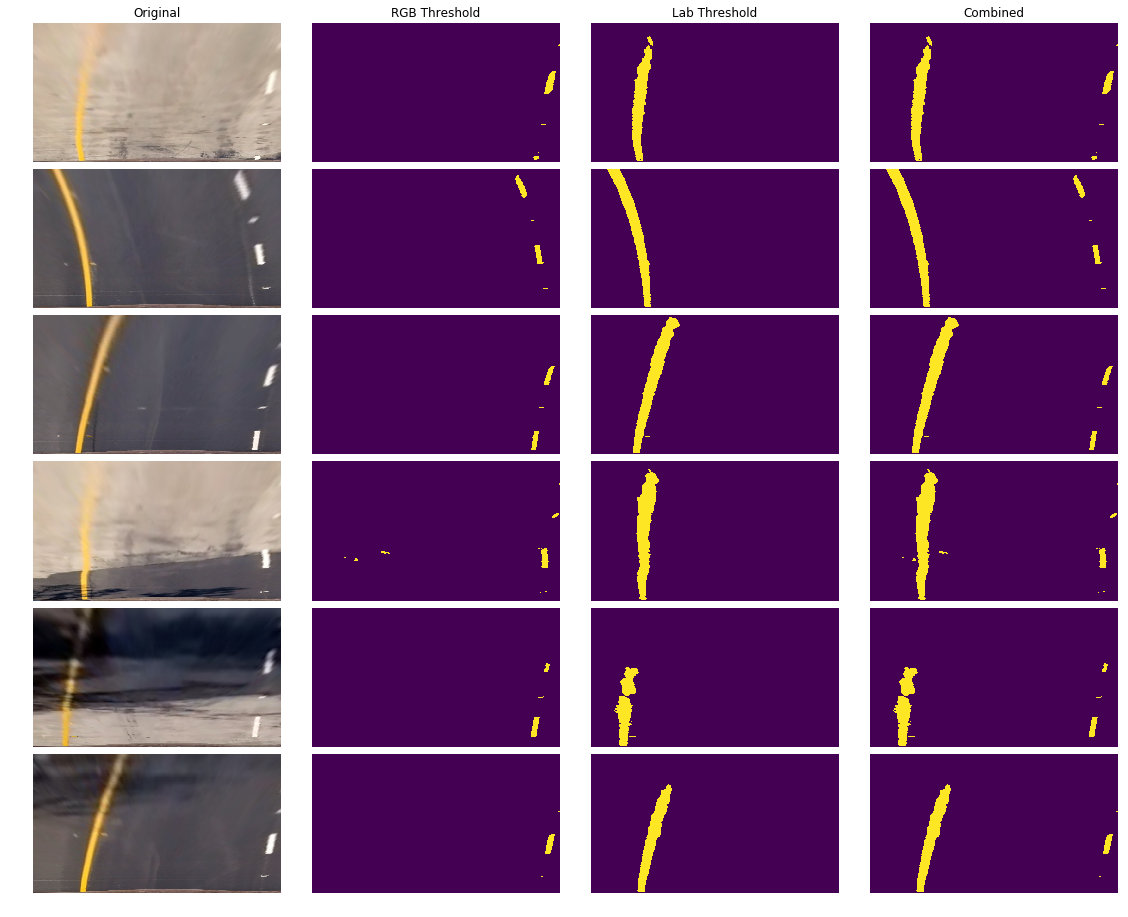

In [7]:
#image = np.copy(test_images[0])
#image = cv2.undistort(image, mtx, dist, None, mtx)
#image = cv2.warpPerspective(image, M, img_size)
#gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
#hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#sobel = abs_sobel_thresh(gray, orient='x', thresh_min=10, thresh_max=255)
#dir_sobel = dir_threshold(gray, sobel_kernel=7, thresh=(0, np.pi/4))
#yellow_line = threshold_yellow(image)
#plt.imshow(yellow_line)
#white_line = threshold_white(image)
#plt.imshow(white_line)
#plt.imshow(g_threshold(image,190,255))
#plt.imshow(sobel)
#hsv_threshold(hsv)
#plt.imshow(threshold(image))

fig, axs = plt.subplots(len(test_images),4, figsize=(20, 16))
fig.subplots_adjust(hspace = .05, wspace=.001)
axs[0][0].set_title("Original")
axs[0][1].set_title("RGB Threshold")
axs[0][2].set_title("Lab Threshold")
axs[0][3].set_title("Combined")

for i in range(len(test_images)):
    for j in range(4):
        axs[i][j].axis('off')
    image = test_images[i]
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image = cv2.warpPerspective(image, M, img_size)
    white = threshold_white(image)
    yellow = threshold_yellow(image)
    combined = threshold(image)
    axs[i][0].imshow(image)
    axs[i][1].imshow(white)
    axs[i][2].imshow(yellow)
    axs[i][3].imshow(combined)

## Visualize Histogram of thresholded pixels

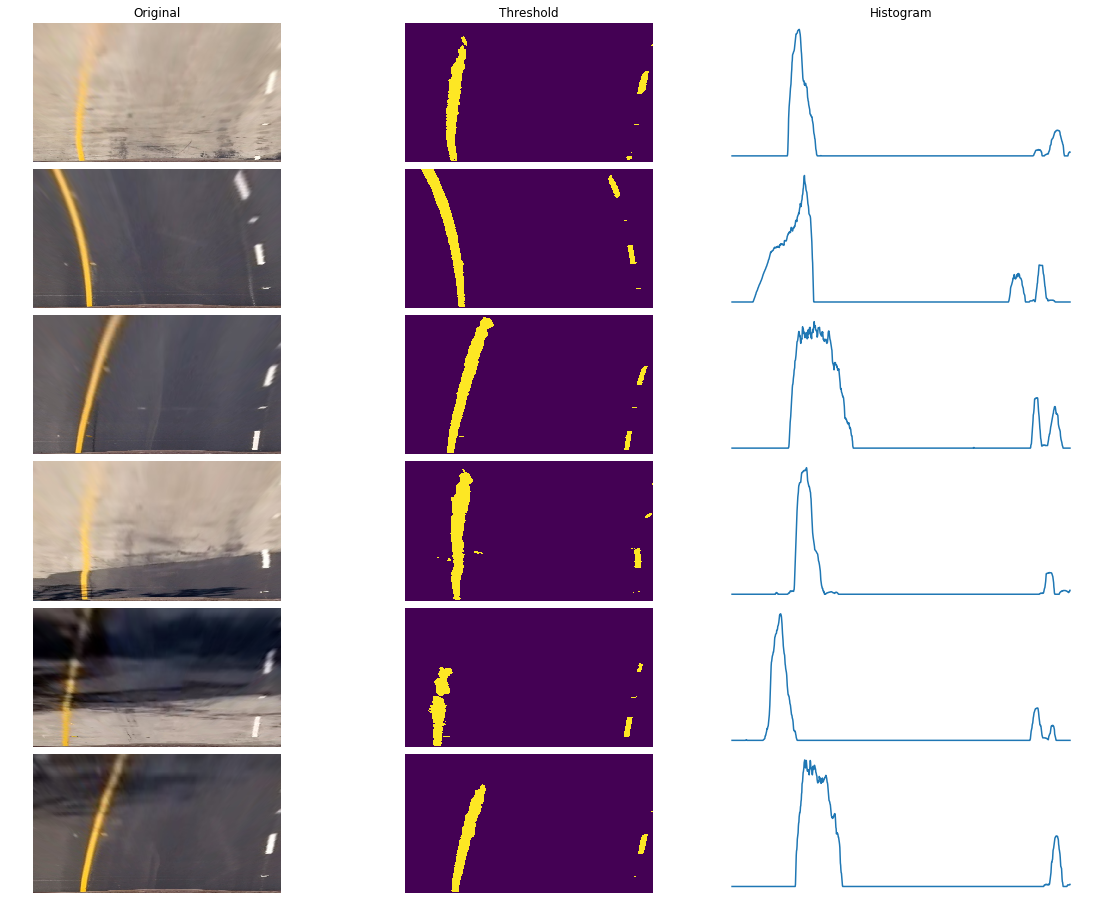

In [8]:
#image = np.copy(test_images[0])
#image = cv2.undistort(image, mtx, dist, None, mtx)
#image = cv2.warpPerspective(image, M, img_size)
#thresh = threshold(image)

#histogram of pixels, used to find approximate lane locations
#histogram = np.sum(thresh, axis=0)
#plt.plot(histogram)

#Peaks indicate likely position of left and right lane lines
#left_lane = np.argmax(histogram[0:np.int(len(histogram)/2)])
#right_lane = np.argmax(histogram[np.int(len(histogram)/2):len(histogram)])+np.int(len(histogram)/2)
#print(left_lane)
#print(right_lane)

fig, axs = plt.subplots(len(test_images),3, figsize=(20, 16))
fig.subplots_adjust(hspace = .05, wspace=.001)
axs[0][0].set_title("Original")
axs[0][1].set_title("Threshold")
axs[0][2].set_title("Histogram")

for i in range(len(test_images)):
    for j in range(3):
        axs[i][j].axis('off')
    image = test_images[i]
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image = cv2.warpPerspective(image, M, img_size)
    thresh = threshold(image)
    histogram = np.sum(thresh, axis=0)    
    axs[i][0].imshow(image)
    axs[i][1].imshow(thresh)
    axs[i][2].plot(histogram)


## Sliding Window Search/Polynomial Fit

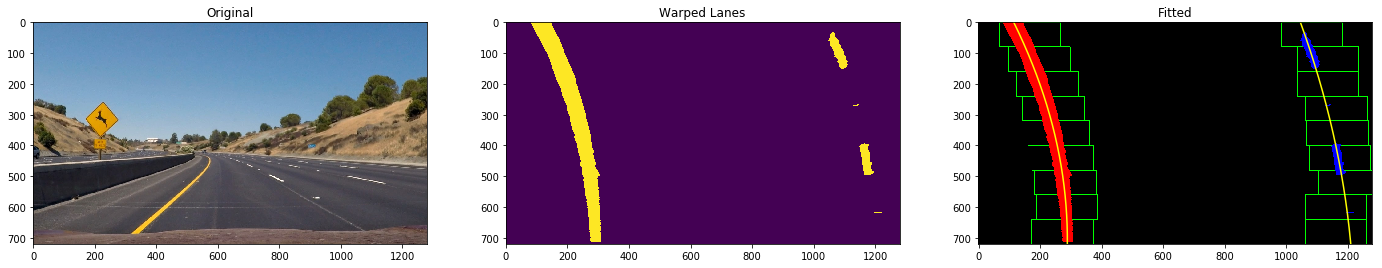

In [25]:
image = np.copy(test_images[1])
undist = cv2.undistort(image, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, img_size)
thresh = threshold(warped)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Generate y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fit, right_fit, out_img


#leftx, lefty, rightx, righty, out_img = find_lane_pixels(thresh)
ploty, left_fit, right_fit, out_img = fit_polynomial(thresh)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(thresh)
ax2.set_title('Warped Lanes')
ax3.imshow(out_img)
ax3.set_title('Fitted')
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')

## Measure Curvature & Offset

In [10]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    avg_curverad = (left_curverad+right_curverad)/2
    
    return left_curverad, right_curverad, avg_curverad

def measure_offset(ploty, left_fit, right_fit):
    y_eval = max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    
    left_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (right_eval-left_eval)/2 + left_eval
    image_center = 1280/2
    offset = (image_center-lane_center)*xm_per_pix
    
    return offset

left_curverad, right_curverad, avg_curverad = measure_curvature_real(ploty, left_fit, right_fit)
offset = measure_offset(ploty, left_fit, right_fit)
print(avg_curverad)
print(offset)

3762.34197962
-0.175472704308


## Inverse Perspective Transform/Lane Projection

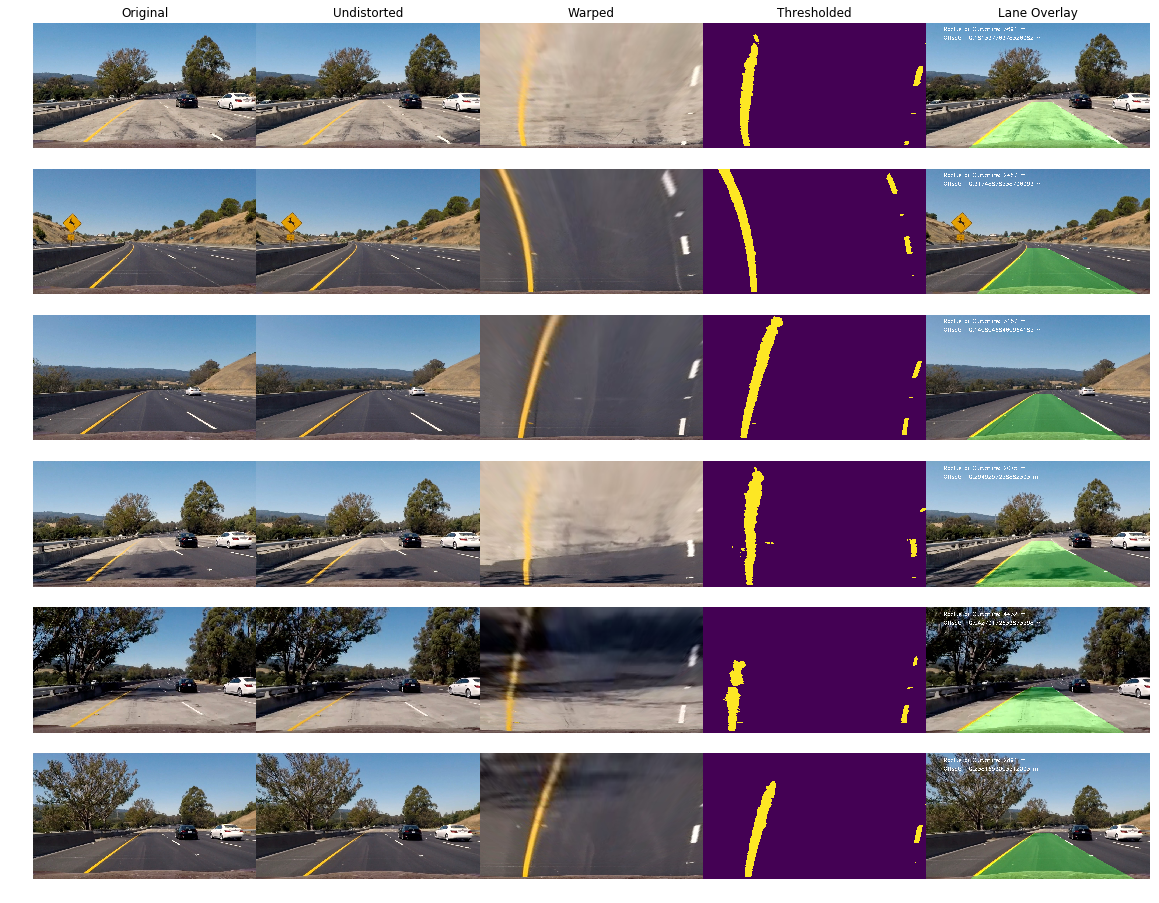

In [11]:
def draw_overlay(undist, thresholded, ploty, left_fit, right_fit, roc, offset, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thresholded).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    overlay = cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    overlay_unwarped = cv2.warpPerspective(overlay, Minv, (undist.shape[1], undist.shape[0]))
    
    # Unwarp the image
    out_img = cv2.addWeighted(undist, 1, overlay_unwarped, 0.3, 0)
    
    # Add text
    font = cv2.FONT_HERSHEY_SIMPLEX
    roc_text = "Radius of Curvature: {} m".format(int(roc))
    cv2.putText(out_img,roc_text,(100,50), font, 1,(255,255,255),2)
    offset_text = "Offset: {} m".format(float(offset))
    cv2.putText(out_img,offset_text,(100,100), font, 1,(255,255,255),2)
    
    return out_img

#image = test_images[0]
#undist = cv2.undistort(image, mtx, dist, None, mtx)
#warped = cv2.warpPerspective(image, M, img_size)
#thresholded = threshold(warped)
#ploty, left_fit, right_fit, out_img = fit_polynomial(thresholded)
#overlay = draw_overlay(undist, thresholded, ploty, left_fit, right_fit, Minv)
#plt.imshow(overlay)

#"""
fig, axs = plt.subplots(len(test_images),5, figsize=(20, 16))
fig.subplots_adjust(hspace = .05, wspace=.001)
axs[0][0].set_title("Original")
axs[0][1].set_title("Undistorted")
axs[0][2].set_title("Warped")
axs[0][3].set_title("Thresholded")
axs[0][4].set_title("Lane Overlay")

for i in range(len(test_images)):
    for j in range(5):
        axs[i][j].axis('off')
    image = test_images[i]
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(image, M, img_size)
    thresholded = threshold(warped)
    ploty, left_fit, right_fit, out_img = fit_polynomial(thresholded)
    left_curverad, right_curverad, roc = measure_curvature_real(ploty, left_fit, right_fit)
    offset = measure_offset(ploty, left_fit, right_fit)
    overlay = draw_overlay(undist, thresholded, ploty, left_fit, right_fit, roc, offset, Minv)
    axs[i][0].imshow(image)
    axs[i][1].imshow(undist)
    axs[i][2].imshow(warped)
    axs[i][3].imshow(thresholded)
    axs[i][4].imshow(overlay)
#"""

## Define class for line tracking

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #RoC
        self.roc = None
        
left_lane = Line()
right_lane = Line()

## Implement Final Pipeline for Video

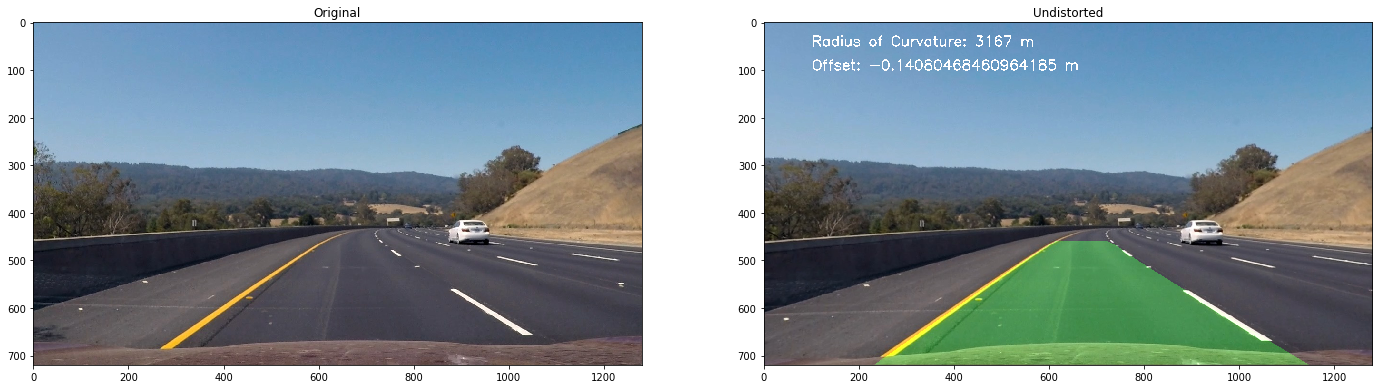

In [17]:
def process_image(image):
    #Step 0: Variables & class declaration
    global lane
    global mtx, dist, M, Minv
    n = 5 #number of "good lanes" for smoothing
    
    #Step 1: Undistort
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #Step 2: Perspective Transform
    warped = cv2.warpPerspective(image, M, img_size)
    #Step 3: Threshold
    thresholded = threshold(warped)
    #Step 4: Fit Polynomial
    ploty, left_fit, right_fit, out_img = fit_polynomial(thresholded)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Step 5: RoC/Offset
    left_roc, right_roc, roc = measure_curvature_real(ploty, left_fit, right_fit)
    offset = measure_offset(ploty, left_fit, right_fit)
    #Step 6: Sanity checks (NOT IMPLEMENTED)
    left_lane.detected = True
    right_lane.detected = True
    #Step 7: Tracking previous lanes and smoothing
    if left_lane.detected & right_lane.detected:
        left_lane.current_fit = [left_fit] 
        right_lane.current_fit = [right_fit] 
        left_lane.recent_xfitted.append(list(left_fitx))
        right_lane.recent_xfitted.append(list(right_fitx))
        left_lane.bestx = np.average(left_lane.recent_xfitted,axis=0)
        right_lane.bestx = np.average(right_lane.recent_xfitted,axis=0)
        left_lane.best_fit = np.polyfit(ploty, left_lane.bestx, 2)
        right_lane.best_fit = np.polyfit(ploty, right_lane.bestx, 2)
        left_lane.roc, right_lane.roc, avg_roc = measure_curvature_real(ploty, left_lane.best_fit, right_lane.best_fit)
    if len(left_lane.recent_xfitted) >= n:
        left_lane.recent_xfitted.pop(0)
    if len(right_lane.recent_xfitted) >= n:
        right_lane.recent_xfitted.pop(0)
    #Step 8: Draw Lane Overlay
    overlay = draw_overlay(undist, thresholded, ploty, left_fit, right_fit, roc, offset, Minv)
    return overlay

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_images[2])
ax1.set_title('Original')
ax2.imshow(process_image(test_images[2]))
ax2.set_title('Undistorted')

In [14]:
#print(np.shape(left_lane.recent_xfitted))
#print(left_lane.best_fit)
#print(left_lane.current_fit)
#print(left_lane.recent_xfitted)
#print(len(left_lane.recent_xfitted))

#print(np.shape(left_lane.recent_xfitted))
#left_avgx=np.average(left_lane.recent_xfitted,axis=0)
#print(np.shape(left_avgx))
#print(left_avgx)
#a = [[1, 2, 3]]
#b = [[4, 5, 6]]
#c = np.concatenate((a,b), axis=0)
#d = np.average(c, axis=0)
#print(c)
#print(d)


## Test on Video

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
video_output  = "output_videos\project_video.mp4"
clip = VideoFileClip('.\project_video.mp4')
processed_clip = clip.fl_image(process_image)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos\project_video.mp4
[MoviePy] Writing video output_videos\project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:11<00:00,  6.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\project_video.mp4 

Wall time: 3min 12s
